In [2]:
# %load /Users/hwayment/ipynb_defaults.py
%load_ext autoreload
%autoreload 2

%pylab inline
import numpy as np
import pandas as pd

import seaborn as sns
sns.set_style('ticks')
sns.set_context('paper')

from matplotlib.colors import LogNorm

from glob import glob
import os, sys, pickle, requests
import EB_stats

sys.path.append('../ChemMapping/scripts')
import RDAT_utils as utils
import plot_utils as eb_plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Populating the interactive namespace from numpy and matplotlib


In [4]:
# load in data
data = pd.read_json('../ChemMapping/data/datasets_with_predictions/filtered_cloud_lab_rounds_26Mar2020.json.zip')

correlation_data = pd.DataFrame()
full_concat_data=pd.DataFrame()

pval_package_list=[ 'vienna_2','nupack_99', 'rnastructure', 'contrafold_2', 'rnasoft_blstar' ]

# process data
for dataset in data['filename'].unique():
    
    print('Analyzing %s' % dataset)
    tmp_data = data.loc[data['filename']==dataset]
    tmp_concat_data = utils.write_concatenated_dataframe(tmp_data)
    
    # filter reactivity outliers
    tmp_concat_data = utils.filter_data(tmp_concat_data)
    
    # remove nucleotides preceded by 6 (or more) A's
    tmp_concat_data = tmp_concat_data.loc[tmp_concat_data['in_polyA']==0]
    tmp_concat_data['dataset'] = dataset
    full_concat_data = full_concat_data.append(tmp_concat_data, ignore_index=True)

    corr_data, pvals = utils.get_correlations(tmp_concat_data, n_bootstraps=100, package_list=pval_package_list)
    corr_data['filename'] = dataset

    #correlation_data = correlation_data.append(corr_data,ignore_index=True)


Analyzing ETERNA_R69_0000.rdat
n_constructs 1088
5345 of 85952 nucleotides removed, 0.06, cutoff = 1.15
Analyzing ETERNA_R70_0000.rdat
n_constructs 101
1084 of 7979 nucleotides removed, 0.14, cutoff = 2.03
Analyzing ETERNA_R71_0000.rdat
n_constructs 843
7788 of 66597 nucleotides removed, 0.12, cutoff = 1.62
Analyzing ETERNA_R72_0000.rdat
n_constructs 354
3945 of 27966 nucleotides removed, 0.14, cutoff = 1.64
Analyzing ETERNA_R73_0000.rdat
n_constructs 641
7960 of 51280 nucleotides removed, 0.16, cutoff = 1.40
Analyzing ETERNA_R74_0000.rdat
n_constructs 681
8811 of 55842 nucleotides removed, 0.16, cutoff = 1.68
Analyzing ETERNA_R75_0000.rdat
n_constructs 522
5675 of 41119 nucleotides removed, 0.14, cutoff = 1.84
Analyzing ETERNA_R76_0000.rdat
n_constructs 547
16691 of 55794 nucleotides removed, 0.30, cutoff = 1.59
Analyzing ETERNA_R77_0002.rdat
n_constructs 666
25986 of 68369 nucleotides removed, 0.38, cutoff = 2.78
Analyzing ETERNA_R78_0001.rdat
n_constructs 683
20263 of 68252 nucleoti

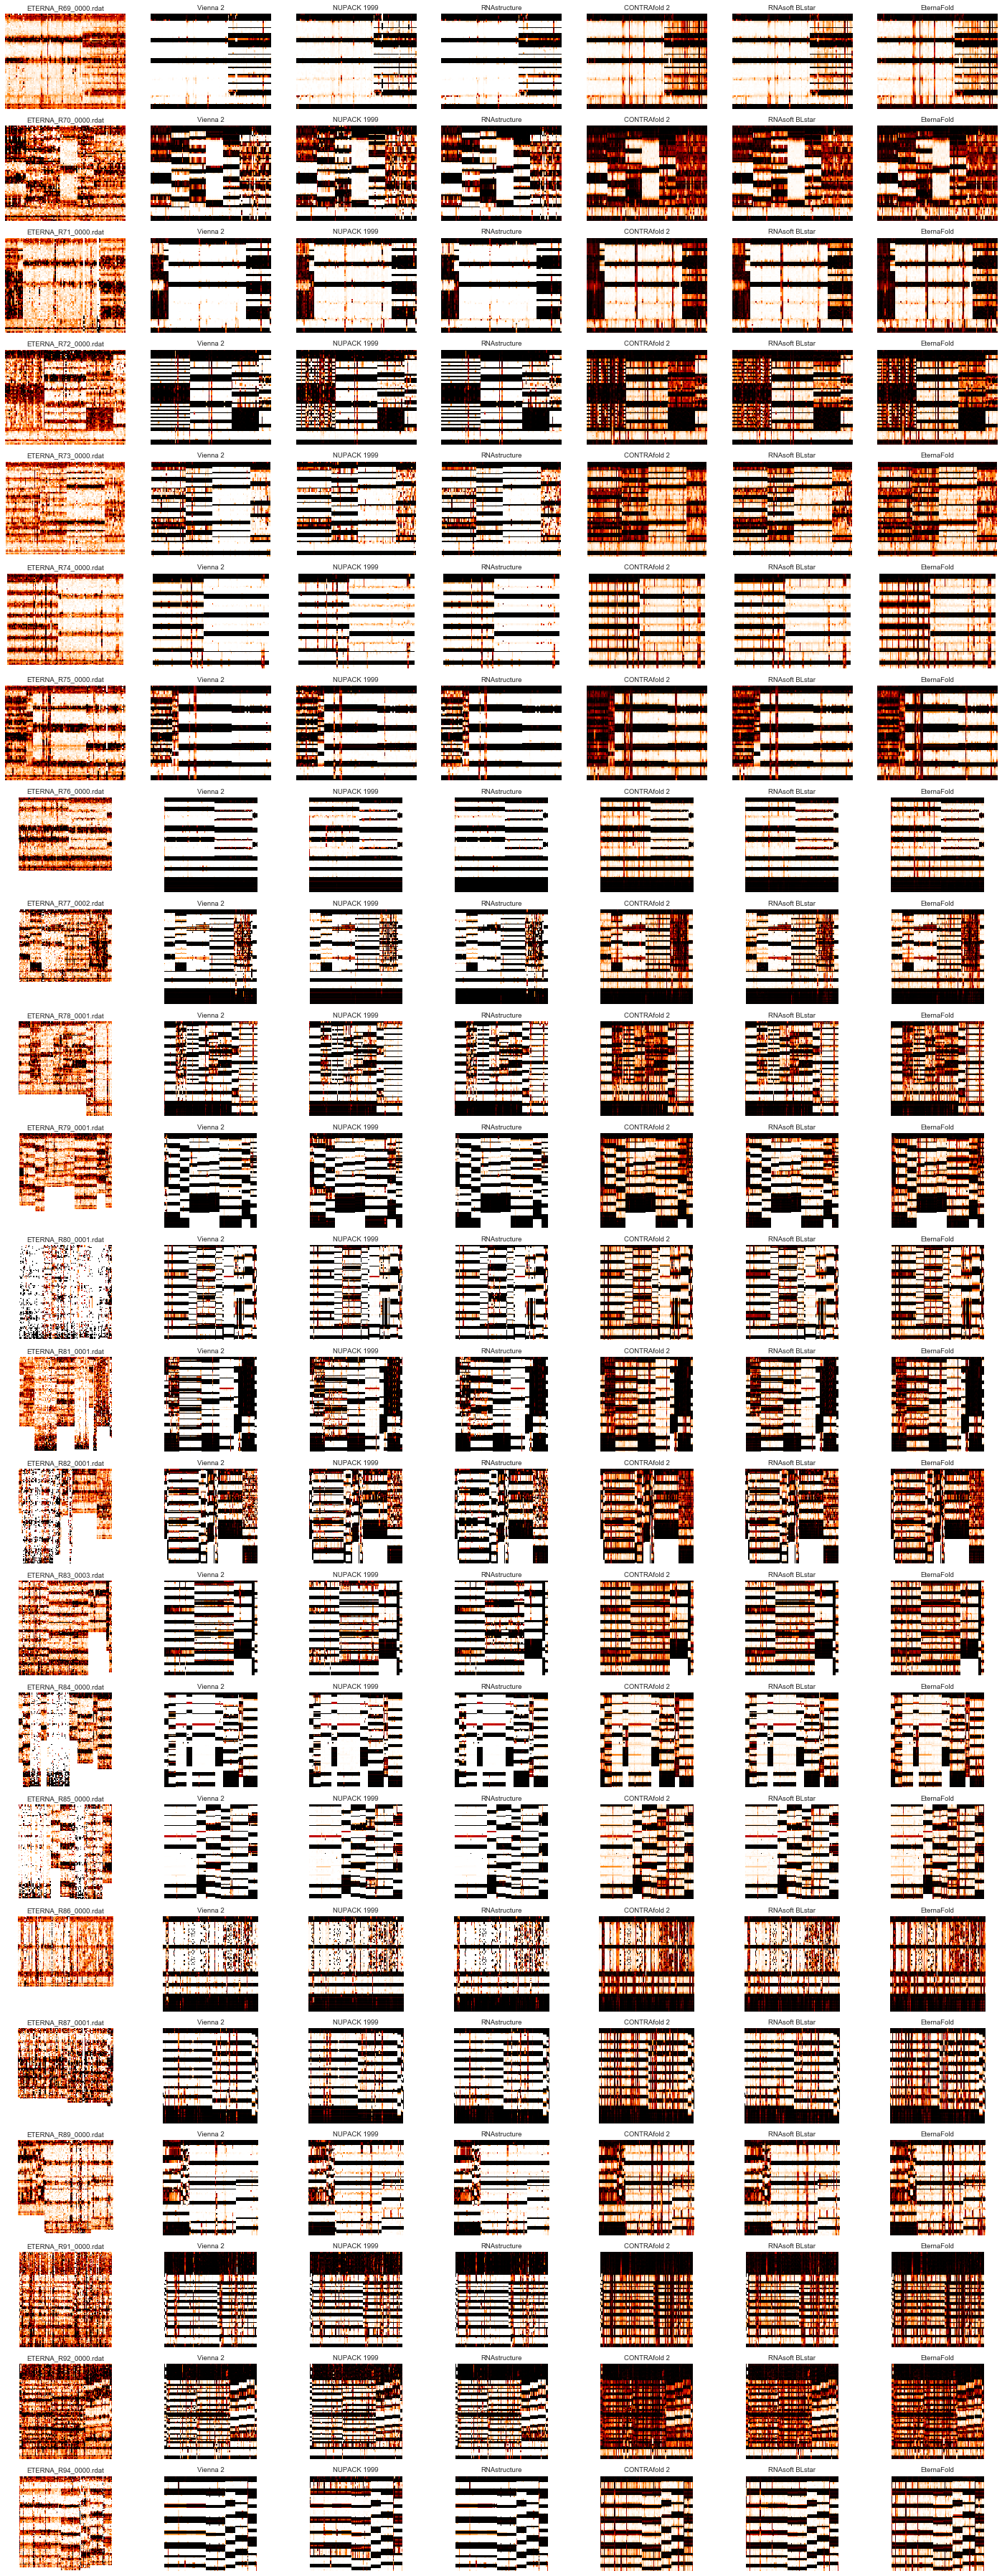

In [69]:
figure(figsize=(20,50))
ctr=1

titles=['Vienna 2', 'NUPACK 1999', 'RNAstructure', 'CONTRAfold 2', 'RNAsoft BLstar', 'EternaFold']
for i, dataset in enumerate(data['filename'].unique()):
    subplot(23,7,ctr)
    eb_plot.plot_reac_heatplot(data.loc[data['filename']==dataset], ind_range=[0,100])
    axis('off')
    title(dataset)
    ctr+=1
    
    for j, pkg in enumerate(['vienna_2', 'nupack_99','rnastructure','contrafold_2','rnasoft_blstar','eternafold_B']):
            subplot(23,7,ctr)
            eb_plot.plot_estimate_heatplot(data.loc[data['filename']==dataset], package=pkg, ind_range=[0,100])
            axis('off')
            ctr+=1
            title(titles[j])

tight_layout()
#savefig('%s/heatplots_all_rounds.pdf' % outdir,bbox_inches='tight')

## Compute correlation between data and package predictions, over all the cloud lab data

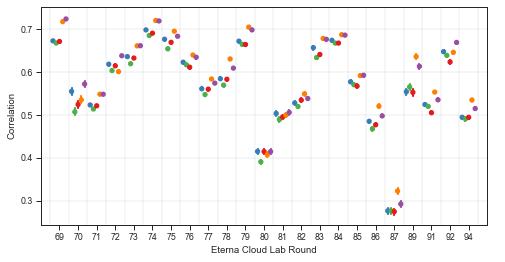

In [100]:
tmp_pal=sns.color_palette('Set1',5)
standardized_palette = [tmp_pal[x] for x in [1,2,0,4,3]]
figure(figsize=(8,4))
sns.pointplot(x='filename', y='Corr', data=correlation_data, hue_order = example_package_list, hue='package',
                      join=False, ci='sd', marker='.', scale=0.75, dodge=0.7, palette=standardized_palette)
legend([], bbox_to_anchor=(1,1), frameon=False)
labels=[x[8:10] for x in correlation_data['filename'].unique()]

xticks([x for x in range(len(labels))], labels)

ylabel('Correlation')
#grid(linewidth=0.2)
for x in range(-1, 23):
    axvline(x+0.5,linewidth=0.2,c='grey',alpha=0.7,zorder=0)
for x in [0.3,0.4,0.5,0.6,0.7]:
    axhline(x,linewidth=0.2,c='grey',alpha=0.7,zorder=0) 

xlim([-1,23])            
xlabel('Eterna Cloud Lab Round')
#savefig('%s/correlation_by_round_-eternafold.pdf' % outdir, bbox_inches='tight',transparent=True)

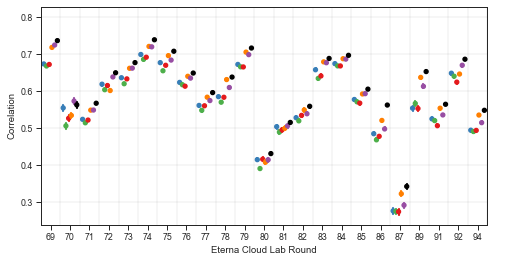

In [16]:
tmp_pal=sns.color_palette('Set1',5)
standardized_palette = [tmp_pal[x] for x in [1,2,0,4,3]]+[[0,0,0]]
figure(figsize=(8,4))
sns.pointplot(x='filename', y='Corr', data=correlation_data, hue_order = example_package_list+['eternafold_B'], hue='package',
                      join=False, ci='sd', marker='.', scale=0.75, dodge=0.7, palette=standardized_palette)
legend([], bbox_to_anchor=(1,1), frameon=False)
labels=[x[8:10] for x in correlation_data['filename'].unique()]

xticks([x for x in range(len(labels))], labels)
#ylim([0.2,0.8])
ylabel('Correlation')
#grid(linewidth=0.2)
for x in range(23):
    axvline(x+0.5,linewidth=0.2,c='grey',alpha=0.7,zorder=0)
for x in [0.3,0.4,0.5,0.6,0.7,0.8]:
    axhline(x,linewidth=0.2,c='grey',alpha=0.7,zorder=0)

xlabel('Eterna Cloud Lab Round')
#savefig('%s/correlation_by_round_+eternafold.pdf' % outdir, bbox_inches='tight',transparent=True)

In [85]:
results = correlation_data.groupby(['filename','package'])['Corr'].agg({'mean','std'})
results = results[['mean','std']]
#results.to_excel('../../excel_files/cloud_lab_rounds.xlsx')

# Perform bootstrapping significance test over all datasets

In [232]:
packages = ['vienna_2', 'nupack_99', 'rnastructure','contrafold_2','rnasoft_blstar']
titles=['Vienna 2', 'NUPACK 1999', 'RNAstructure', 'CONTRAfold 2', 'RNAsoft BLstar']

arr = EB_stats.bootstrap_all_datasets(full_concat_data, x_data='reactivity', y_data='p', package_list= packages, n_bootstraps=1000)

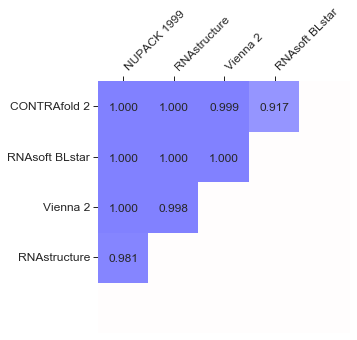

In [245]:
fig = EB_stats.plot_net_overview(arr, package_list=packages,titles=titles, reorder=[0,2,1,3,4], fontsize=12, figsize=(5,5))

fig.savefig('net_pvalues_correlation_maintext.pdf',bbox_inches='tight',transparent=True)

In [5]:
per_dataset_tests = EB_stats.sig_over_individual_datasets(full_concat_data, x_data='reactivity', y_data='p', package_list= pval_package_list, n_bootstraps=1000)

ETERNA_R69_0000.rdat
ETERNA_R70_0000.rdat
ETERNA_R71_0000.rdat
ETERNA_R72_0000.rdat
ETERNA_R73_0000.rdat
ETERNA_R74_0000.rdat
ETERNA_R75_0000.rdat
ETERNA_R76_0000.rdat
ETERNA_R77_0002.rdat
ETERNA_R78_0001.rdat
ETERNA_R79_0001.rdat
ETERNA_R80_0001.rdat
ETERNA_R81_0001.rdat
ETERNA_R82_0001.rdat
ETERNA_R83_0003.rdat
ETERNA_R84_0000.rdat
ETERNA_R85_0000.rdat
ETERNA_R86_0000.rdat
ETERNA_R87_0001.rdat
ETERNA_R89_0000.rdat
ETERNA_R91_0000.rdat
ETERNA_R92_0000.rdat
ETERNA_R94_0000.rdat


In [8]:
pval_package_list

['vienna_2', 'nupack_99', 'rnastructure', 'contrafold_2', 'rnasoft_blstar']

<Figure size 720x1080 with 0 Axes>

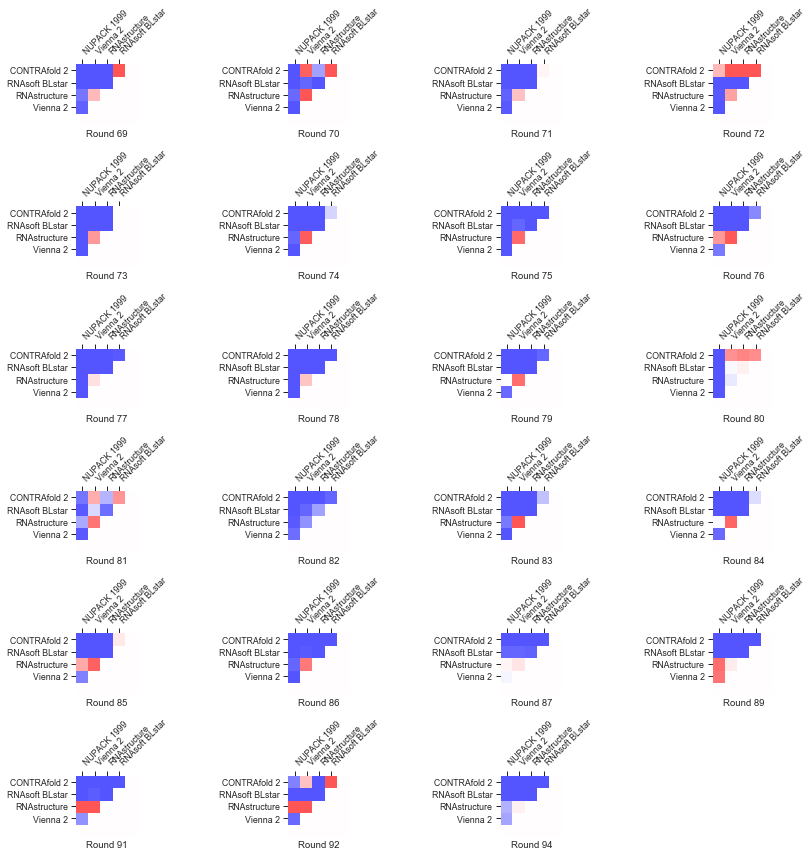

In [10]:
figure(figsize=(10,15))
packages = ['vienna_2', 'nupack_99', 'rnastructure','contrafold_2','rnasoft_blstar']
titles=['Vienna 2', 'NUPACK 1999', 'RNAstructure', 'CONTRAfold 2', 'RNAsoft BLstar']

dataset_names = ['Round %s' % k[8:10] for k in per_dataset_tests.keys()]

fig = EB_stats.plot_pairwise_matrices(per_dataset_tests, n_rows=6, n_cols=4, reorder=[1,0,2,4,3],
        package_list = packages, titles = titles, labels=False, figsize=(12,12), dataset_titles=dataset_names)

fig.savefig('pairwise_matrices_per_dataset_cloud_labs.pdf',bbox_inches='tight',transparent=True)